 $$\Large Interação \ e \ Concorreência$$
 $$\large Trabalho \ Prático \ - \ Computação \ Quântica$$
 
 - Diogo Aires - A91685
 - Nuno Machado - A68702

In [1]:
    from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute
    from qiskit.tools.visualization import plot_histogram, plot_distribution
    from qiskit.tools.visualization import circuit_drawer
    from qiskit.circuit.library import ZGate, MCXGate
    import matplotlib.pyplot as plt
    import numpy as np

$\Large Fórmula \ Booleana$

$$f(v1,v2,v3) = (\neg v1 \lor  \neg v2 \lor \neg v3) \land (v1 \lor  \neg v2 \lor v3) \land (v1 \lor v2 \lor \neg v3) \land (v1 \lor \neg v2 \lor \neg v3)\land (\neg v1 \lor v2 \lor v3)$$

cuja tabela de verdade é dada por:


|v1|v2|v3|c1|c2|c3|c4|c5|f(v1,v2,v3)|
|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|1|1|1|0|1|1|1|1|0
|0|0|0|1|1|1|1|1|1
|1|0|0|1|1|1|1|0|0
|0|1|0|1|0|1|1|1|0
|0|0|1|1|1|0|1|1|0
|1|1|0|1|1|1|1|1|1
|0|1|1|1|1|1|0|1|0
|1|0|1|1|1|1|1|1|1

Daqui rapidamente conseguimos concluir que a fórmula é satisfazível para:
- $v1=0;\ v2=0;\ v3=0;$
- $v1=1;\ v2=1;\ v3=0;$
- $v1=1;\ v2=0;\ v3=1;$

$\large Execução \ do \ Algoritmo$

In [2]:
n_qubits = 3
elements = 2**n_qubits
solutions=["000","110","101"]

- $\textbf{execute_circuit}$ : Responsável por executar um circuito quântico num simulador (neste caso, o simulador qasm_simulator do pacote Aer do Qiskit) e retornar os resultados na forma de um dicionário. Se decimal for True, converte os resultados binários em números decimais.Se reversed for True, inverte a ordem dos bits no resultado.

In [3]:
def execute_circuit(qc, shots=1024, decimal=False, reversed=False): 
        #define backend 
        device = Aer.get_backend('qasm_simulator') 
        #get counts 
        counts = execute(qc, device, shots=shots).result().get_counts() 
         
        if decimal: 
            if reversed: 
                counts = dict((int(a[::-1],2),b) for (a,b) in counts.items()) 
            else: 
                counts = dict((int(a,2),b) for (a,b) in counts.items()) 
        else: 
            if reversed: 
                counts = dict((a[::-1],b) for (a,b) in counts.items()) 
            else: 
                counts = dict((a,b) for (a,b) in counts.items()) 
     
        return counts 

- $\textbf{init}$ : Inicializa um circuito quântico com 3 qubits e 1 para ancilla. Além disso, ela cria um registrador clássico de 3 bits. Aplica o gate Hadamard em todos os qubits em qr, e, de seguida aplica o gate X e Hadamard em ancilla. Seguidamenete, adiciona uma barreira ao circuito e retorna-o, juntamente com os registradores.

In [4]:
def init():
    qr=QuantumRegister(3) 
    ancilla=QuantumRegister(1) 
    cr=ClassicalRegister(3) 
    qc =QuantumCircuit(qr,ancilla,cr) 
 
    #preparacao estado incial 
    qc.h(qr) 
    qc.x(ancilla) 
    qc.h(ancilla) 
    qc.barrier() 
    return qc, qr, ancilla, cr

- $\textbf{oracle}$ :  Cria um circuito quântico que implementa um oráculo específico, usado no algoritmo de Grover. Recebe como entrada o registrador de qubits qr, o registrador de ancilla ancilla e a solução solution. Aplica um gate controlado de n-qubits, usando solution como control, aos qubits em qr. De seguida, adiciona uma barreira ao circuito e retorna-o.

In [5]:
def oracle(qr, ancilla, solution=None):
    qc = QuantumCircuit(qr,ancilla) 
    cx_gate = MCXGate(len(qr), ctrl_state=solution)
    qc=qc.compose(cx_gate)
    
    qc.barrier() 
    return qc 

- $\textbf{diffusion_operator}$ :  implementa o operador de difusão num circuito quântico. Aplica a sequência de gates HXH para inverter o estado do qubit mais significativo em qr. Em seguida, aplica o gate de control-Z para os demais qubits, com o qubit mais significativo em qr como control. Finalmente, aplica a sequência HXH novamente para reverter o estado do qubit mais significativo em qr. Adiciona uma barreira ao circuito e retorna-o.

In [6]:
def diffusion_operator(qr, ancilla):  
    qc = QuantumCircuit(qr,ancilla)
    
    qc.h(qr)
    qc.x(qr[-1])
    cz = ZGate().control(n_qubits-1,ctrl_state="0"*(n_qubits-1))
    qc = qc.compose(cz)
    qc.x(qr[-1])

    qc.h(qr) 
 
    qc.barrier() 
 
    return qc

- $\textbf{grover}$ : Implementa o algoritmo de busca de Grover num circuito quântico. Calcula o número de iterações necessárias para o algoritmo de Grover, com base no número de soluções e no número total de elementos a serem pesquisados. Em seguida, itera sobre as soluções, aplicando o oráculo quântico e o operador de difusão quântico em cada iteração. Retorna o circuito quântico modificado. Calcula o número de iterações necessárias para o algoritmo de Grover, com base no número de soluções e no número total de elementos a serem pesquisados. Em seguida, itera sobre as soluções, aplicando o oráculo quântico e o operador de difusão quântico em cada iteração. Retorna o circuito quântico modificado.

In [7]:
def grover(qc, qr, ancilla, solution):
    elements = 2**n_qubits
    #numero de iteracoes 
    iterations = int(np.floor(np.pi/4 * np.sqrt(elements/len(solutions)))) 
    
    #iteracoes  
    for i in range(iterations):
        for solution in solutions:
            qc = qc.compose(oracle(qr,ancilla, solution=solution)) 
        qc = qc.compose(diffusion_operator(qr,ancilla)) 
    return qc

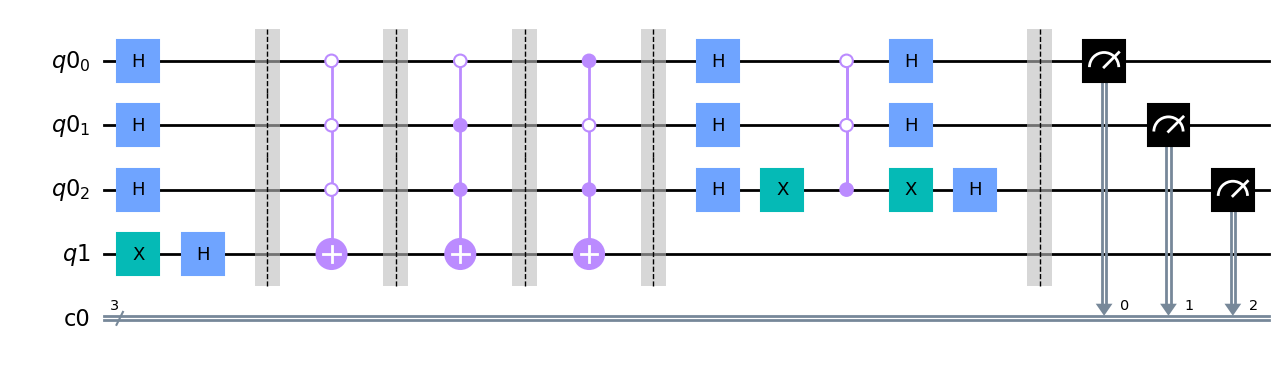

In [8]:
qc, qr, ancilla, cr = init()
qc=grover(qc,qr,ancilla,solutions)
qc.measure(qr,cr) 
#executar o circuito e mostrar os resultados 
 
qc.draw(output="mpl")

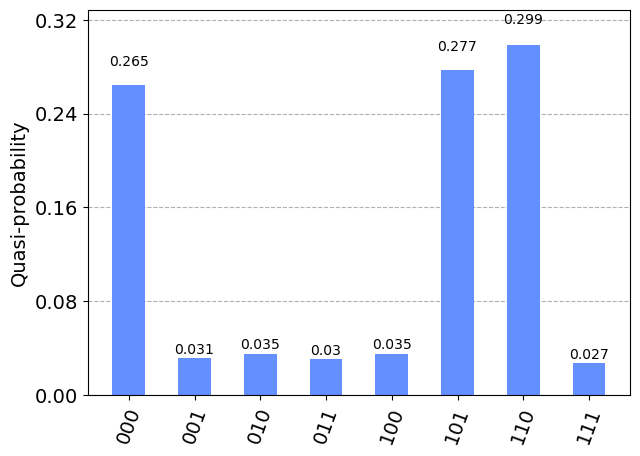

In [9]:
counts = execute_circuit(qc, shots=1024) 
plot_distribution(counts) 

Como esperado, as soluções obtidas foram:
- 000
- 110
- 101